# 0. Install and load packages

In [1]:
# install.packages("tidyverse")
# install.packages("rvest")
# install.packages("gridExtra")
# install.packages("ggcorrplot")
options(warn=-1)
library(tidyverse)
library(rvest)
library(gridExtra)
library(ggcorrplot)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: xml2

Attaching package: 'rvest'

The following object is masked from 'package:purrr':

    pluck

The following object is masked from 'package:readr':

    guess_encoding


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



# 1. Web scraping for a single team

## 1.1 Boston Celtics roster

In [2]:
celtics_link = "https://www.espn.com/nba/team/roster/_/name/bos/boston-celtics"
celtics_page = read_html(celtics_link)
name = celtics_page %>% html_nodes(".Table__TD+ .Table__TD .AnchorLink") %>% html_text()
position = celtics_page %>% html_nodes(".Table__TD:nth-child(3) .inline") %>% html_text()
age = celtics_page %>% html_nodes(".Table__TD:nth-child(4) .inline") %>% html_text()
height = celtics_page %>% html_nodes(".Table__TD:nth-child(5) .inline") %>% html_text()
weight = celtics_page %>% html_nodes(".Table__TD:nth-child(6) .inline") %>% html_text()
college = celtics_page %>% html_nodes(".Table__TD:nth-child(7) .inline") %>% html_text()
salary = celtics_page %>% html_nodes(".Table__TD:nth-child(8) .inline") %>% html_text()

# Create data frame
celtics_df = data.frame("name" = name, "position" = position, "age" = age,
"height" = height, "weight" = weight, "college" = college, "salary" = salary)
head(celtics_df, 10)

name,position,age,height,weight,college,salary
Malcolm Brogdon,PG,29,"6' 5""",229 lbs,Virginia,"$22,600,000"
Jaylen Brown,SG,25,"6' 6""",223 lbs,California,"$28,741,071"
JD Davison,G,19,"6' 3""",195 lbs,Alabama,--
Danilo Gallinari,F,34,"6' 10""",236 lbs,--,"$6,479,000"
Sam Hauser,SF,24,"6' 8""",215 lbs,Virginia,"$1,563,518"
Al Horford,C,36,"6' 9""",240 lbs,Florida,"$26,500,000"
Mfiondu Kabengele,C,25,"6' 10""",250 lbs,Florida State,"$1,701,593"
Luke Kornet,F,27,"7' 2""",250 lbs,Vanderbilt,"$2,133,278"
Payton Pritchard,PG,24,"6' 1""",195 lbs,Oregon,"$2,239,200"
Matt Ryan,F,25,"6' 7""",215 lbs,Chattanooga,--


## 1.2 Boston Celtics players statistics (regular season)

In [3]:
get_stats = function(link) {
  page = read_html(link)
  stats = page %>% html_nodes(".pv3 .clr-gray-02") %>% html_text() %>% paste(collapse = ", ")
  return(stats)
}

celtics_stats_link = celtics_page %>% html_nodes(".Table__TD+ .Table__TD .AnchorLink") %>% html_attr("href")
stats = unname(sapply(celtics_stats_link, FUN=get_stats))

In [4]:
celtics_df$stats = stats
celtics_df = separate(celtics_df, stats, sep=", ", into=c("points", "assist", "rebound", "efficiency_rating"))
head(celtics_df, 10)

name,position,age,height,weight,college,salary,points,assist,rebound,efficiency_rating
Malcolm Brogdon,PG,29,"6' 5""",229 lbs,Virginia,"$22,600,000",19.1,5.1,5.9,18.10
Jaylen Brown,SG,25,"6' 6""",223 lbs,California,"$28,741,071",23.6,6.1,3.5,18.98
JD Davison,G,19,"6' 3""",195 lbs,Alabama,--,,NA,NA,NA
Danilo Gallinari,F,34,"6' 10""",236 lbs,--,"$6,479,000",11.7,4.7,1.5,14.35
Sam Hauser,SF,24,"6' 8""",215 lbs,Virginia,"$1,563,518",2.5,1.1,0.4,14.80
Al Horford,C,36,"6' 9""",240 lbs,Florida,"$26,500,000",10.2,7.7,3.4,16.71
Mfiondu Kabengele,C,25,"6' 10""",250 lbs,Florida State,"$1,701,593",2.4,1.5,0.4,9.59
Luke Kornet,F,27,"7' 2""",250 lbs,Vanderbilt,"$2,133,278",2.0,1.9,0.6,17.16
Payton Pritchard,PG,24,"6' 1""",195 lbs,Oregon,"$2,239,200",6.2,1.9,2.0,14.95
Matt Ryan,F,25,"6' 7""",215 lbs,Chattanooga,--,3.0,0.0,0.0,3.56


# 2. Automate scraping for all NBA teams

In [5]:
nba_teams = c("bkn/brooklyn-nets", "bos/boston-celtics", "ny/new-york-knicks", "phi/philadelphia-76ers", "tor/toronto-raptors", 
          "chi/chicago-bulls", "cle/cleveland-cavaliers", "det/detroit-pistons", "ind/indiana-pacers", "mil/milwaukee-bucks",
          "atl/atlanta-hawks", "cha/charlotte-hornets", "mia/miami-heat", "orl/orlando-magic", "wsh/washington-wizards",
          "gs/golden-state-warriors", "lac/la-clippers", "lal/los-angeles-lakers", "phx/phoenix-suns", "sac/sacramento-kings",
          "dal/dallas-mavericks", "hou/houston-rockets", "mem/memphis-grizzlies", "no/new-orleans-pelicans", "sa/san-antonio-spurs",
          "den/denver-nuggets", "min/minnesota-timberwolves", "okc/oklahoma-city-thunder", "por/portland-trail-blazers", "utah/utah-jazz"
         )

get_stats = function(link) {
  page = read_html(link)
  stats = page %>% html_nodes(".pv3 .clr-gray-02") %>% html_text() %>% paste(collapse = ", ")
  return(stats)
}

nba_df = data.frame()

start_time = Sys.time()

for (team in nba_teams) {
    link = paste0("https://www.espn.com/nba/team/roster/_/name/", team)
    page = read_html(link)
    # Player profile
    name = page %>% html_nodes(".Table__TD+ .Table__TD .AnchorLink") %>% html_text()
    position = page %>% html_nodes(".Table__TD:nth-child(3) .inline") %>% html_text()
    age = page %>% html_nodes(".Table__TD:nth-child(4) .inline") %>% html_text()
    height = page %>% html_nodes(".Table__TD:nth-child(5) .inline") %>% html_text()
    weight = page %>% html_nodes(".Table__TD:nth-child(6) .inline") %>% html_text()
    college = page %>% html_nodes(".Table__TD:nth-child(7) .inline") %>% html_text()
    salary = page %>% html_nodes(".Table__TD:nth-child(8) .inline") %>% html_text()
    # Player stats
    stats_link = page %>% html_nodes(".Table__TD+ .Table__TD .AnchorLink") %>% html_attr("href")
    stats = unname(sapply(stats_link, FUN=get_stats))
    # Rbind
    nba_df = rbind(nba_df, data.frame(name, position, age, height, weight, college, salary, team, stats))
}

end_time = Sys.time()
end_time - start_time

Time difference of 8.84079 mins

In [6]:
head(nba_df)

name,position,age,height,weight,college,salary,team,stats
LaMarcus Aldridge,C,37,"6' 11""",250 lbs,Texas,--,bkn/brooklyn-nets,"12.9, 5.5, 0.9, 19.69"
Nic Claxton,PF,23,"6' 11""",215 lbs,Georgia,"$8,500,000",bkn/brooklyn-nets,"8.7, 5.6, 0.9, 18.66"
Seth Curry,SG,32,"6' 2""",185 lbs,Duke,"$8,496,500",bkn/brooklyn-nets,"15.0, 3.1, 3.6, 13.70"
David Duke Jr.,SF,22,"6' 4""",204 lbs,Providence,--,bkn/brooklyn-nets,"4.7, 3.0, 0.8, 10.07"
Kevin Durant,PF,33,"6' 10""",240 lbs,Texas,"$44,119,845",bkn/brooklyn-nets,"29.9, 7.4, 6.4, 25.69"
Blake Griffin,PF,33,"6' 9""",250 lbs,Oklahoma,--,bkn/brooklyn-nets,"6.4, 4.1, 1.9, 13.77"


# 3. Data cleaning

In [7]:
nba_df_clean = separate(nba_df, stats, sep=", ", into=c("points", "assist", "rebound", "efficiency_rating"))
head(nba_df_clean)

name,position,age,height,weight,college,salary,team,points,assist,rebound,efficiency_rating
LaMarcus Aldridge,C,37,"6' 11""",250 lbs,Texas,--,bkn/brooklyn-nets,12.9,5.5,0.9,19.69
Nic Claxton,PF,23,"6' 11""",215 lbs,Georgia,"$8,500,000",bkn/brooklyn-nets,8.7,5.6,0.9,18.66
Seth Curry,SG,32,"6' 2""",185 lbs,Duke,"$8,496,500",bkn/brooklyn-nets,15.0,3.1,3.6,13.70
David Duke Jr.,SF,22,"6' 4""",204 lbs,Providence,--,bkn/brooklyn-nets,4.7,3.0,0.8,10.07
Kevin Durant,PF,33,"6' 10""",240 lbs,Texas,"$44,119,845",bkn/brooklyn-nets,29.9,7.4,6.4,25.69
Blake Griffin,PF,33,"6' 9""",250 lbs,Oklahoma,--,bkn/brooklyn-nets,6.4,4.1,1.9,13.77


In [8]:
height_in_cm = nba_df %>% separate(height, into=c("feet", "inches"), convert=TRUE) %>% transmute(height = feet * 30.48 + inches * 2.54)
nba_df_clean$height = height_in_cm[['height']]
nba_df_clean$weight = round(as.numeric(gsub('lbs', '', nba_df$weight)) / 2.205, 2)
nba_df_clean$salary = as.numeric(gsub('[$,]', '', nba_df$salary))
head(nba_df_clean)

name,position,age,height,weight,college,salary,team,points,assist,rebound,efficiency_rating
LaMarcus Aldridge,C,37,210.82,113.38,Texas,NA,bkn/brooklyn-nets,12.9,5.5,0.9,19.69
Nic Claxton,PF,23,210.82,97.51,Georgia,8500000,bkn/brooklyn-nets,8.7,5.6,0.9,18.66
Seth Curry,SG,32,187.96,83.90,Duke,8496500,bkn/brooklyn-nets,15.0,3.1,3.6,13.70
David Duke Jr.,SF,22,193.04,92.52,Providence,NA,bkn/brooklyn-nets,4.7,3.0,0.8,10.07
Kevin Durant,PF,33,208.28,108.84,Texas,44119845,bkn/brooklyn-nets,29.9,7.4,6.4,25.69
Blake Griffin,PF,33,205.74,113.38,Oklahoma,NA,bkn/brooklyn-nets,6.4,4.1,1.9,13.77


In [9]:
nba_df_clean[nba_df_clean$college == "--", "college"] = NA

clean_team_names = function(name) {
    if(name == "bkn/brooklyn-nets") {
        res = "Brooklyn Nets"
    } else if(name == "bos/boston-celtics") {
        res = "Boston Celtics"
    } else if(name == "ny/new-york-knicks") {
        res = "New York Knicks"
    } else if(name == "phi/philadelphia-76ers") {
        res = "Philadelphia 76ers"
    } else if(name == "tor/toronto-raptors") {
        res = "Toronto Raptors"
    } else if(name == "chi/chicago-bulls") {
        res = "Chicago Bulls"
    } else if(name == "cle/cleveland-cavaliers") {
        res = "Cleveland Cavaliers"
    } else if(name == "det/detroit-pistons") {
        res = "Detroit Pistons"
    } else if(name == "ind/indiana-pacers") {
        res = "Indiana Pacers"
    } else if(name == "mil/milwaukee-bucks") {
        res = "Milwaukee Bucks"
    } else if(name == "atl/atlanta-hawks") {
        res = "Atlanta Hawks"
    } else if(name == "cha/charlotte-hornets") {
        res = "Charlotte Hornets"
    } else if(name == "mia/miami-heat") {
        res = "Miami Heat"
    } else if(name == "orl/orlando-magic") {
        res = "Orlando Magic"
    } else if(name == "wsh/washington-wizards") {
        res = "Washington Wizards"
    } else if(name == "gs/golden-state-warriors") {
        res = "Golden State Warriors"
    } else if(name == "lac/la-clippers") {
        res = "Los Angeles Clippers"
    } else if(name == "lal/los-angeles-lakers") {
        res = "Los Angeles Lakers"
    } else if(name == "phx/phoenix-suns") {
        res = "Phoenix Suns"
    } else if(name == "sac/sacramento-kings") {
        res = "Sacremento Kings"
    } else if(name == "dal/dallas-mavericks") {
        res = "Dallas Mavericks"
    } else if(name == "hou/houston-rockets") {
        res = "Houston Rockets"
    } else if(name == "mem/memphis-grizzlies") {
        res = "Memphis Grizzlies"
    } else if(name == "no/new-orleans-pelicans") {
        res = "New Orleans Pelicans"
    } else if(name == "sa/san-antonio-spurs") {
        res = "San Antonio Spurs"
    } else if(name == "den/denver-nuggets") {
        res = "Denver Nuggets"
    } else if(name == "min/minnesota-timberwolves") {
        res = "Minnesota Timberwolves"
    } else if(name == "okc/oklahoma-city-thunder") {
        res = "Oklahoma City Thunder"
    } else if(name == "por/portland-trail-blazers") {
        res = "Portland Trail Blazers"
    } else {
        res = "Utah Jazz"
    }
    return(res)
}
nba_df_clean$team = as.factor(sapply(nba_df_clean$team, clean_team_names))
head(nba_df_clean)

name,position,age,height,weight,college,salary,team,points,assist,rebound,efficiency_rating
LaMarcus Aldridge,C,37,210.82,113.38,Texas,NA,Brooklyn Nets,12.9,5.5,0.9,19.69
Nic Claxton,PF,23,210.82,97.51,Georgia,8500000,Brooklyn Nets,8.7,5.6,0.9,18.66
Seth Curry,SG,32,187.96,83.90,Duke,8496500,Brooklyn Nets,15.0,3.1,3.6,13.70
David Duke Jr.,SF,22,193.04,92.52,Providence,NA,Brooklyn Nets,4.7,3.0,0.8,10.07
Kevin Durant,PF,33,208.28,108.84,Texas,44119845,Brooklyn Nets,29.9,7.4,6.4,25.69
Blake Griffin,PF,33,205.74,113.38,Oklahoma,NA,Brooklyn Nets,6.4,4.1,1.9,13.77


In [10]:
str(nba_df_clean)

'data.frame':	597 obs. of  12 variables:
 $ name             : Factor w/ 597 levels "Alondes Williams",..: 11 13 16 5 9 3 8 10 14 12 ...
 $ position         : Factor w/ 7 levels "C","G","PF","PG",..: 1 3 6 5 3 3 5 4 4 3 ...
 $ age              : Factor w/ 23 levels "20","22","23",..: 11 3 8 2 9 9 7 6 10 9 ...
 $ height           : num  211 211 188 193 208 ...
 $ weight           : num  113.4 97.5 83.9 92.5 108.8 ...
 $ college          : Factor w/ 140 levels "Baylor","Duke",..: 11 3 2 9 11 8 12 2 10 4 ...
 $ salary           : num  NA 8500000 8496500 NA 44119845 ...
 $ team             : Factor w/ 30 levels "Atlanta Hawks",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ points           : chr  "12.9" "8.7" "15.0" "4.7" ...
 $ assist           : chr  "5.5" "5.6" "3.1" "3.0" ...
 $ rebound          : chr  "0.9" "0.9" "3.6" "0.8" ...
 $ efficiency_rating: chr  "19.69" "18.66" "13.70" "10.07" ...


In [11]:
nba_df_clean$name = as.character(nba_df_clean$name)
nba_df_clean$age = as.numeric(levels(nba_df_clean$age))[nba_df_clean$age]
nba_df_clean$points = as.numeric(nba_df_clean$points)
nba_df_clean$assist = as.numeric(nba_df_clean$assist)
nba_df_clean$rebound = as.numeric(nba_df_clean$rebound)
nba_df_clean$efficiency_rating = as.numeric(nba_df_clean$efficiency_rating)

In [12]:
str(nba_df_clean)

'data.frame':	597 obs. of  12 variables:
 $ name             : chr  "LaMarcus Aldridge" "Nic Claxton" "Seth Curry" "David Duke Jr." ...
 $ position         : Factor w/ 7 levels "C","G","PF","PG",..: 1 3 6 5 3 3 5 4 4 3 ...
 $ age              : num  37 23 32 22 33 33 31 30 34 33 ...
 $ height           : num  211 211 188 193 208 ...
 $ weight           : num  113.4 97.5 83.9 92.5 108.8 ...
 $ college          : Factor w/ 140 levels "Baylor","Duke",..: 11 3 2 9 11 8 12 2 10 4 ...
 $ salary           : num  NA 8500000 8496500 NA 44119845 ...
 $ team             : Factor w/ 30 levels "Atlanta Hawks",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ points           : num  12.9 8.7 15 4.7 29.9 6.4 11.3 27.4 11.4 7.6 ...
 $ assist           : num  5.5 5.6 3.1 3 7.4 4.1 4 4.4 1.9 2.6 ...
 $ rebound          : num  0.9 0.9 3.6 0.8 6.4 1.9 1 5.8 2.3 1.4 ...
 $ efficiency_rating: num  19.7 18.7 13.7 10.1 25.7 ...


In [13]:
# write.csv(nba_df_clean, "C:/Users/JChong/Downloads/nba.csv", row.names=FALSE)

# 4. Basic exploratory data analysis

In [14]:
head(nba_df_clean)

name,position,age,height,weight,college,salary,team,points,assist,rebound,efficiency_rating
LaMarcus Aldridge,C,37,210.82,113.38,Texas,NA,Brooklyn Nets,12.9,5.5,0.9,19.69
Nic Claxton,PF,23,210.82,97.51,Georgia,8500000,Brooklyn Nets,8.7,5.6,0.9,18.66
Seth Curry,SG,32,187.96,83.90,Duke,8496500,Brooklyn Nets,15.0,3.1,3.6,13.70
David Duke Jr.,SF,22,193.04,92.52,Providence,NA,Brooklyn Nets,4.7,3.0,0.8,10.07
Kevin Durant,PF,33,208.28,108.84,Texas,44119845,Brooklyn Nets,29.9,7.4,6.4,25.69
Blake Griffin,PF,33,205.74,113.38,Oklahoma,NA,Brooklyn Nets,6.4,4.1,1.9,13.77


## 4.1 Height and weight distribution by player position

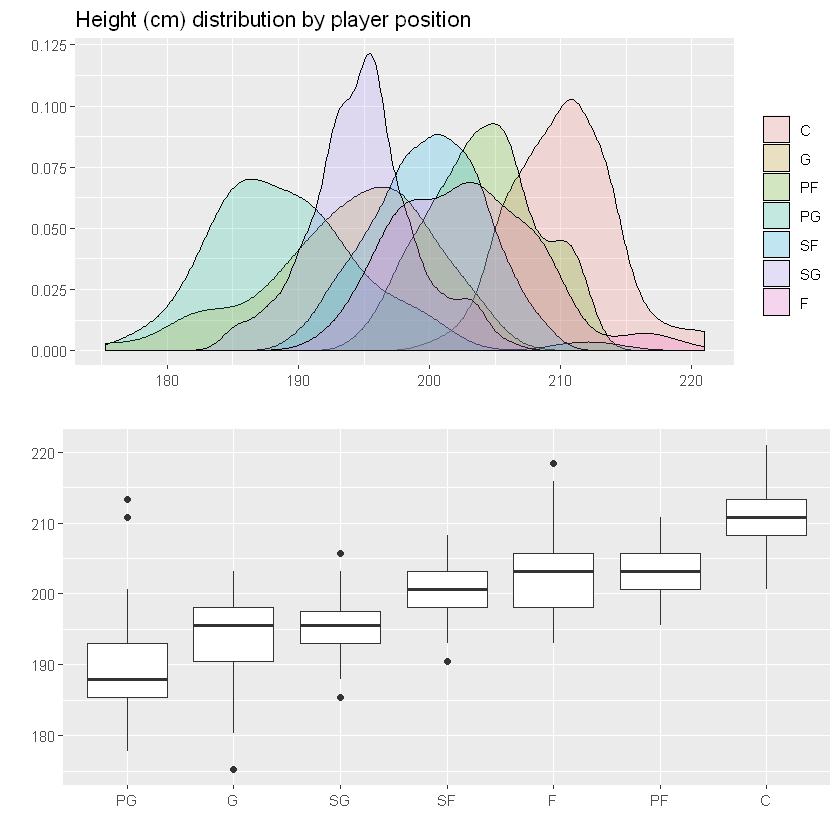

In [15]:
height_density = nba_df_clean %>% ggplot(aes(x=height, fill=position)) + geom_density(position="identity", alpha=0.2, bins=50) + xlab("") + ylab("") + scale_fill_discrete("") + ggtitle("Height (cm) distribution by player position")
height_box = nba_df_clean %>% ggplot(aes(x=reorder(position, height, na.rm=TRUE), y=height)) + geom_boxplot() + xlab("") + ylab("")
grid.arrange(height_density, height_box, ncol=1)

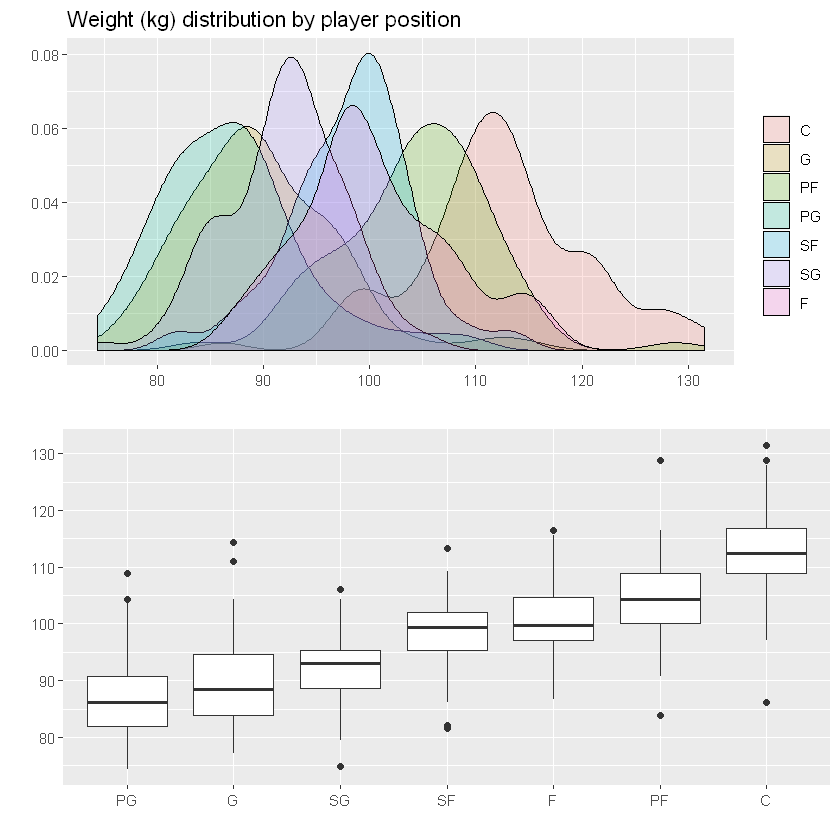

In [16]:
weight_density = nba_df_clean %>% ggplot(aes(x=weight, fill=position)) + geom_density(position="identity", alpha=0.2, bins=50) + xlab("") + ylab("") + scale_fill_discrete("") + ggtitle("Weight (kg) distribution by player position")
weight_box = nba_df_clean %>% ggplot(aes(x=reorder(position, weight, na.rm=TRUE), y=weight)) + geom_boxplot() + xlab("") + ylab("")
grid.arrange(weight_density, weight_box, ncol=1)

## 4.2 Correlation between numeric variables

In [17]:
nba_df_numeric = nba_df_clean[, c("age", "height", "weight", "salary", "points", "assist", "rebound", "efficiency_rating")]
correlation = round(cor(nba_df_numeric, use="complete.obs"), 2)

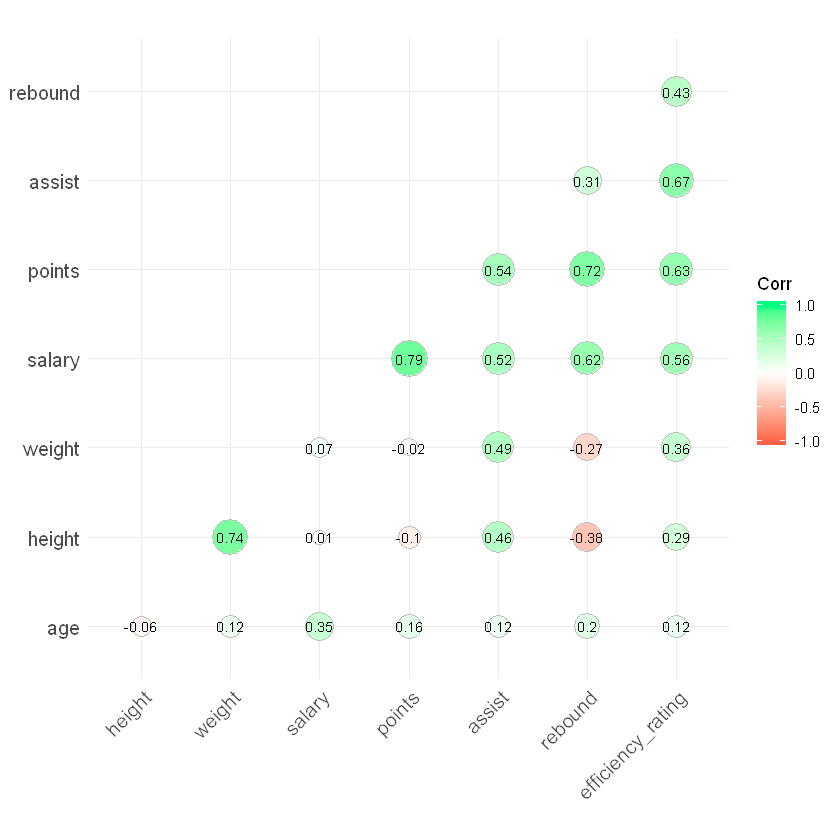

In [18]:
ggcorrplot(correlation, type="lower", lab=TRUE, lab_size=3, method="circle", colors = c("tomato", "white", "springgreen"))

Two interesting call-outs would be: (1) average points scored per game is highly positively correlated to salary and (2) height is negatively correlated with average rebounds per game. 

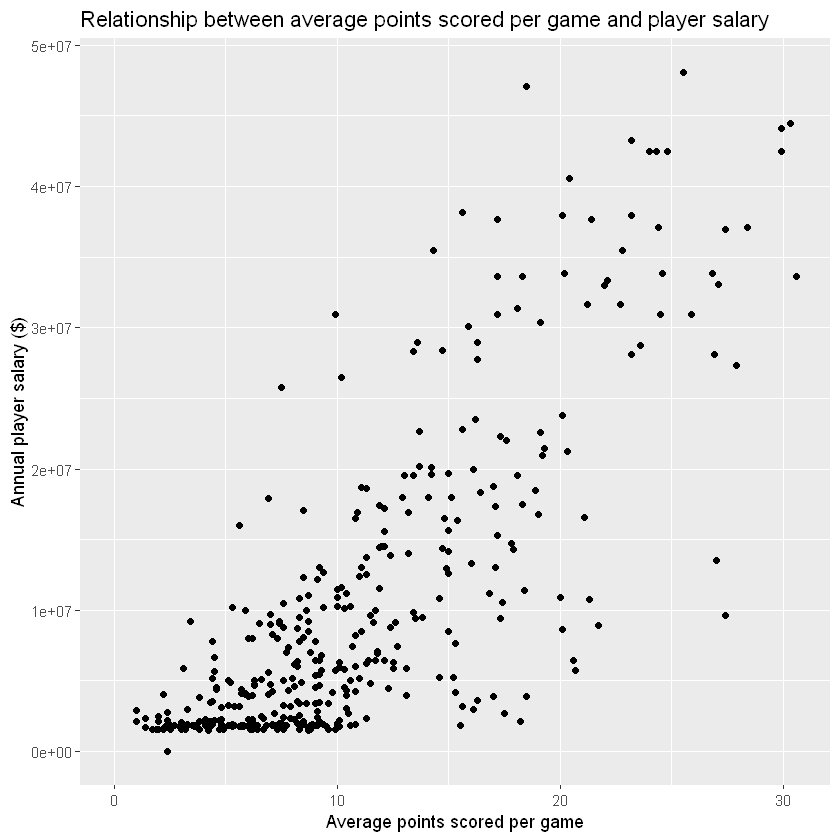

In [19]:
nba_df_clean %>% ggplot(aes(x=points, y=salary)) + geom_point() + ggtitle("Relationship between average points scored per game and player salary") + xlab("Average points scored per game") + ylab("Annual player salary ($)")

## 4.3 College alumni

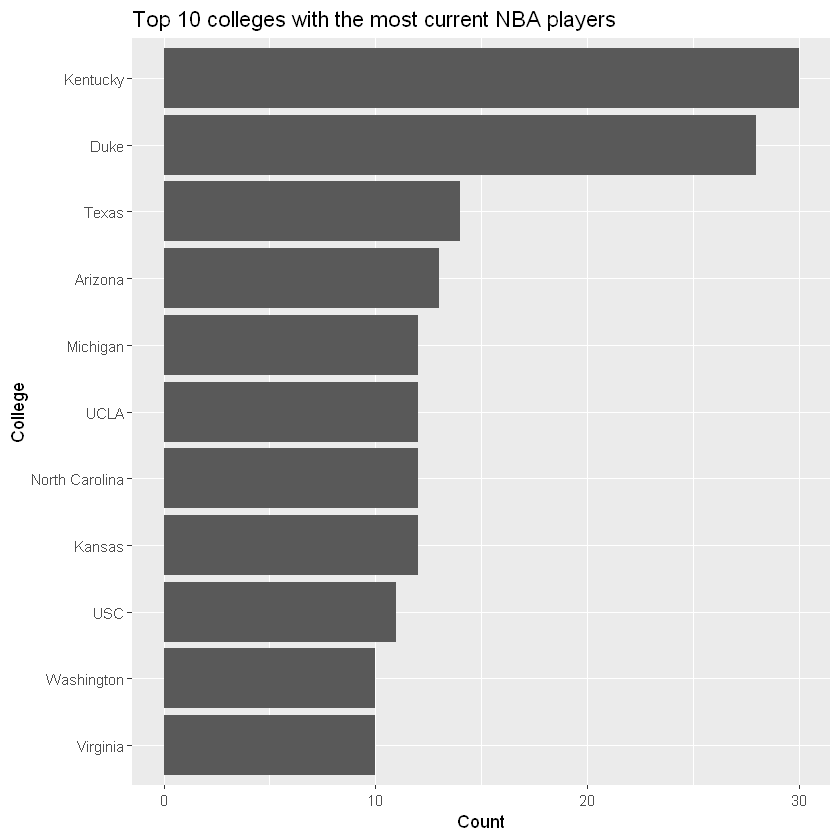

In [20]:
college = nba_df_clean %>% group_by(college) %>% summarise(college_count=length(na.omit(college))) %>% top_n(n=10, college_count)
college %>% ggplot(aes(reorder(college, college_count), college_count)) + geom_bar(stat="identity") + coord_flip() + ggtitle("Top 10 colleges with the most current NBA players") + xlab("College") + ylab("Count")

## 4.4 Highest paid NBA players

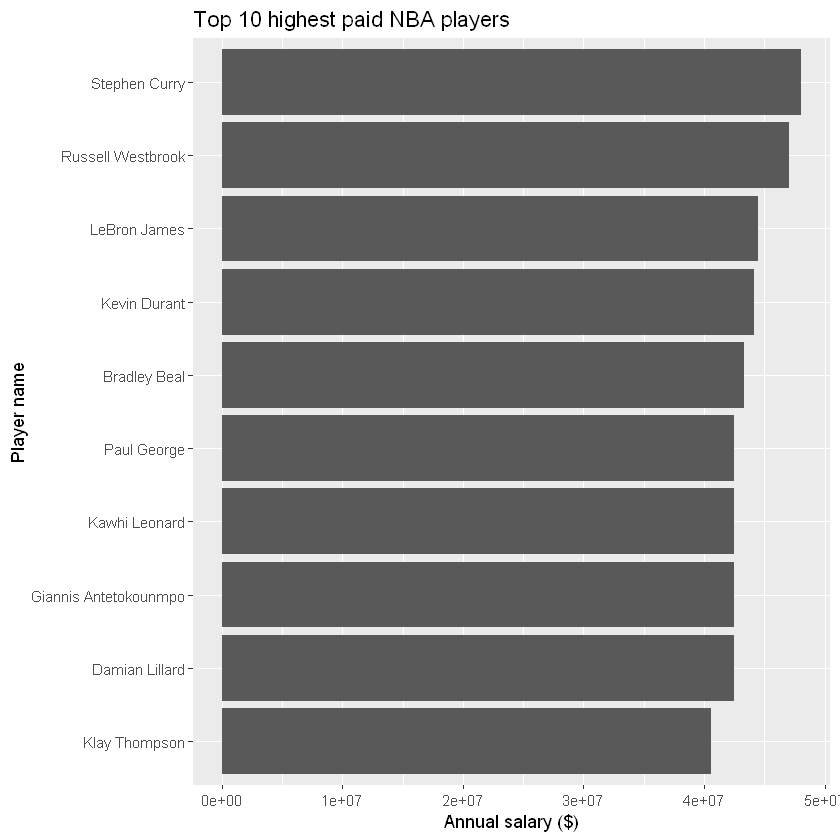

In [21]:
nba_df_clean %>% top_n(10, salary) %>% ggplot(aes(reorder(name, salary), salary)) + geom_bar(stat="identity") + coord_flip() + ggtitle("Top 10 highest paid NBA players") + xlab("Player name") + ylab("Annual salary ($)")